In [128]:
import pandas as pd
import numpy as np
import re
import nltk
# nltk.download() #下载nltk所需语料库等内容，直接点击左下角download即可

# 1. 读取数据

In [2]:
yahoopath = 'yahoopw.csv'
yahoo_pass_data = pd.read_csv(yahoopath, encoding = 'GBK')

In [7]:
yahoo_pass_data.head() #查看数据前五项

passwd
0  @fl!pm0de@
1        pass
2     steveol
3      chotzi
4      lb2512

# 2. 建立语料库
论文要求：当代美国英语语料库中，根据据有普遍意义的演讲段落进行语法标注（1-grams，2-grams，3-grams）了的词汇，姓名，月份，城市名，国家名等。分两个语料库（source_corpora， reference_corpora），为了了提高效率。

其中姓名，月份，主要国家[1],COCA的“I”，“a”，2-grams的频率前37，3-grams去掉频率最后100作为source_corpora <br>
COCA的1-grams，2-grams，3-grams作为reference_corpora

In [119]:
# from nltk.corpus import brown    #导入brown语料库

# brown.fileids()

namespath = "./names.csv"
countrypath = "./main_countrys.csv"

namesinfo = pd.read_csv(namespath) #按照使用频率
names = namesinfo.sort_values("counts",ascending=False)["name"]

months = pd.Series(["Jan", "January", "Feb", "February", "Mar", "March", "Apr", "April",  "May", "May", "Jun", "June",
          "Jul", "July", "Aug", "August", "Sept", "September", "Oct", "October", "Nov", "November", "Dec", "December"])

countrys = pd.read_csv(countrypath)

COCA_1_grams= pd.read_table('words_frequency.txt',header=None,names=['Word', 'Tag', 'Frequency', 'Dispersion'], sep='\t',index_col=0)
COCA_2_grams= pd.read_table('w2c.txt',header=None,names=['Frequency', 'Word1', 'Word2', 'Tag1', 'Tag2'], sep='\t')
COCA_3_grams= pd.read_table('w2c.txt',header=None,names=['Frequency', 'Word1', 'Word2', 'Word3', 'Tag1', 'Tag2', 'Tag3'], sep='\t')
print(COCA_1_grams.head())
print(COCA_2_grams.head())
print(COCA_3_grams.head())

     Word Tag  Frequency  Dispersion
1     the   a   22038615        0.98
2      be   v   12545825        0.97
3     and   c   10741073        0.99
4      of   i   10343885        0.97
5       a   a   10144200        0.98
   Frequency Word1    Word2 Tag1 Tag2
0        268     a        a  at1  at1
1         31     a      AAA  at1  np1
2         39     a       an  at1  at1
3        185     a      and  at1   cc
4         39     a  another  at1  dd1
   Frequency Word1    Word2 Word3 Tag1  Tag2  Tag3
0        268     a        a   at1  at1   NaN   NaN
1         31     a      AAA   at1  np1   NaN   NaN
2         39     a       an   at1  at1   NaN   NaN
3        185     a      and   at1   cc   NaN   NaN
4         39     a  another   at1  dd1   NaN   NaN


In [135]:
COCA_2_grams_sorted = COCA_2_grams.sort_values("Frequency")
COCA_3_grams_sorted = COCA_3_grams.sort_values("Frequency")

In [129]:
print(len(COCA_2_grams))
print(len(COCA_3_grams))
print(names.head())
print(months.head())
print(countrys.head())

1048720
1048720
0          Emma
18309      Liam
1        Olivia
18310      Noah
2           Ava
Name: name, dtype: object
0         Jan
1     January
2         Feb
3    February
4         Mar
dtype: object
       country
0       Angola
1  Afghanistan
2      Albania
3      Algeria
4      Andorra


### 2.1 source_corpora

姓名，月份，主要国家[1],COCA的“I”，“a”，2-grams的频率前37，3-grams去掉频率最后100

In [150]:
source_corpora = names.append(months)
source_corpora = pd.concat([source_corpora, countrys["country"]])
source_corpora = pd.concat([source_corpora, pd.Series(["I", "a"])])
print(len(source_corpora))

words_2 = list(set(COCA_2_grams_sorted["Word1"]).union(set(COCA_2_grams_sorted["Word2"])))
words_3 = list(set(COCA_3_grams_sorted["Word1"]).union(set(COCA_3_grams_sorted["Word2"])).union(set(COCA_3_grams_sorted["Word3"])))
words = pd.Series(list(set(words_2).intersection(set(words_3))))

source_corpora = pd.concat([source_corpora, words])
print(len(words))
print(len(source_corpora))

32687
76357
109044


In [151]:
source_corpora.to_csv("./source_corpora.csv",sep=",", index=0)

## 2.2 reference_corpora

姓名，月份，主要国家[1],COCA

In [156]:
reference_source = [COCA_1_grams, COCA_2_grams_sorted, COCA_3_grams_sorted, names, months, main_countrys]

# 3. 进行断词

论文要求：根据上述语料库进行断词<br>

1. 找到所有可能的子串W
2. 字串如果在上述语料库中，则为words（单词段），否则为gaps(间隙段)，去掉所有的间隙段，生成C
3. 计算最有可能的分段阈值Theta(计算方法见3.1)
4. 去掉C中小于阈值Theta的后选项
5. 计算得到C中最有可能的候选项分段t
6. 将间隙段重新插入得到的t
7. 返回分段结果

例子：输入ilove123you <br>
    输出['i', 'love', '123', 'you']

In [157]:
def word_breaking(password):
    W = [password[i:i + x + 1] for x in range(len(password)) for i in range(len(password) - x)]
    return W
    

In [158]:
print(word_breaking("asdf"))
print(word_breaking("asdf12sadsa12e"))

['a', 's', 'd', 'f', 'as', 'sd', 'df', 'asd', 'sdf', 'asdf']
['a', 's', 'd', 'f', '1', '2', 's', 'a', 'd', 's', 'a', '1', '2', 'e', 'as', 'sd', 'df', 'f1', '12', '2s', 'sa', 'ad', 'ds', 'sa', 'a1', '12', '2e', 'asd', 'sdf', 'df1', 'f12', '12s', '2sa', 'sad', 'ads', 'dsa', 'sa1', 'a12', '12e', 'asdf', 'sdf1', 'df12', 'f12s', '12sa', '2sad', 'sads', 'adsa', 'dsa1', 'sa12', 'a12e', 'asdf1', 'sdf12', 'df12s', 'f12sa', '12sad', '2sads', 'sadsa', 'adsa1', 'dsa12', 'sa12e', 'asdf12', 'sdf12s', 'df12sa', 'f12sad', '12sads', '2sadsa', 'sadsa1', 'adsa12', 'dsa12e', 'asdf12s', 'sdf12sa', 'df12sad', 'f12sads', '12sadsa', '2sadsa1', 'sadsa12', 'adsa12e', 'asdf12sa', 'sdf12sad', 'df12sads', 'f12sadsa', '12sadsa1', '2sadsa12', 'sadsa12e', 'asdf12sad', 'sdf12sads', 'df12sadsa', 'f12sadsa1', '12sadsa12', '2sadsa12e', 'asdf12sads', 'sdf12sadsa', 'df12sadsa1', 'f12sadsa12', '12sadsa12e', 'asdf12sadsa', 'sdf12sadsa1', 'df12sadsa12', 'f12sadsa12e', 'asdf12sadsa1', 'sdf12sadsa12', 'df12sadsa12e', 'asdf12sad

## 3.1 得分计算算法
- 论文算法2

1.	根据字符串长度计算其的得分
2.	如果字符串长度k＞3，则分别将该字符串分割为a1[0:1] a2[1:k]或者a3[0:3] a4[4:k],再分别回到1进行计算，直到得到最高得分的分割方法 <br>
基于参考语料库，算法2中的N-GramProperty计算方式定义如下：<br>
P(w1...wn) = f(w1...wn)/f(Kn)<br>
Kn：语料库K中所有的N元语义（N元语义：由N个字母组成的单词）<br>
F(Kn)：在语料库K中N元语义的总频率<br>
P(w1...wn)：N元语义在N元语料库中的比例<br>
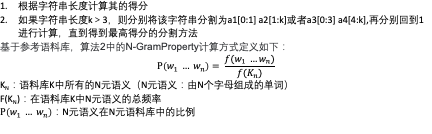

## 3.2 根据得分返回一个口令最有可能的分段方式

# 4. 词性分析
利用nltk里的WordNet库进行词性分析 <br>
论文提到需要多步，本文先用WordNet进行简单标注

## 4.1 进行词性标注
利用nltk里的WordNet库

## 4.2 泛化
利用nltk里的WordNet库对取得的单词进行泛化，如：<br>
蝴蝶 -> 昆虫 -> 动物<br>
论文提到了泛化步骤及抽象等级确定算法

## 4.3 调整语义泛化树到WordNet

# 5. 语义预测机

# 6. 附录

- [1] 主要国家名

In [42]:
import json

main_countrys_temp = json.loads(json.dumps([
  "Angola-安哥拉-0244",
  "Afghanistan-阿富汗-93",
  "Albania-阿尔巴尼亚-335",
  "Algeria-阿尔及利亚-213",
  "Andorra-安道尔共和国-376",
  "Anguilla-安圭拉岛-1254",
  "Antigua and Barbuda-安提瓜和巴布达-1268",
  "Argentina-阿根廷-54",
  "Armenia-亚美尼亚-374",
  "Ascension-阿森松-247",
  "Australia-澳大利亚-61",
  "Austria-奥地利-43",
  "Azerbaijan-阿塞拜疆-994",
  "Bahamas-巴哈马-1242",
  "Bahrain-巴林-973",
  "Bangladesh-孟加拉国-880",
  "Barbados-巴巴多斯-1246",
  "Belarus-白俄罗斯-375",
  "Belgium-比利时-32",
  "Belize-伯利兹-501",
  "Benin-贝宁-229",
  "Bermuda Is-百慕大群岛-1441",
  "Bolivia-玻利维亚-591",
  "Botswana-博茨瓦纳-267",
  "Brazil-巴西-55",
  "Brunei-文莱-673",
  "Bulgaria-保加利亚-359",
  "Burkina Faso-布基纳法索-226",
  "Burma-缅甸-95",
  "Burundi-布隆迪-257",
  "Cameroon-喀麦隆-237",
  "Canada-加拿大-1",
  "Cayman Is-开曼群岛-1345",
  "Central African Republic-中非共和国-236",
  "Chad-乍得-235",
  "Chile-智利-56",
  "China-中国-86",
  "Colombia-哥伦比亚-57",
  "Congo-刚果-242",
  "Cook Is-库克群岛-682",
  "Costa Rica-哥斯达黎加-506",
  "Cuba-古巴-53",
  "Cyprus-塞浦路斯-357",
  "Czech Republic-捷克-420",
  "Denmark-丹麦-45",
  "Djibouti-吉布提-253",
  "Dominica Rep-多米尼加共和国-1890",
  "Ecuador-厄瓜多尔-593",
  "Egypt-埃及-20",
  "EI Salvador-萨尔瓦多-503",
  "Estonia-爱沙尼亚-372",
  "Ethiopia-埃塞俄比亚-251",
  "Fiji-斐济-679",
  "Finland-芬兰-358",
  "France-法国-33",
  "French Guiana-法属圭亚那-594",
  "French Polynesia-法属玻利尼西亚-689",
  "Gabon-加蓬-241",
  "Gambia-冈比亚-220",
  "Georgia-格鲁吉亚-995",
  "Germany-德国-49",
  "Ghana-加纳-233",
  "Gibraltar-直布罗陀-350",
  "Greece-希腊-30",
  "Grenada-格林纳达-1809",
  "Guam-关岛-1671",
  "Guatemala-危地马拉-502",
  "Guinea-几内亚-224",
  "Guyana-圭亚那-592",
  "Haiti-海地-509",
  "Honduras-洪都拉斯-504",
  "Hongkong-香港-852",
  "Hungary-匈牙利-36",
  "Iceland-冰岛-354",
  "India-印度-91",
  "Indonesia-印度尼西亚-62",
  "Iran-伊朗-98",
  "Iraq-伊拉克-964",
  "Ireland-爱尔兰-353",
  "Israel-以色列-972",
  "Italy-意大利-39",
  "Ivory Coast-科特迪瓦-225",
  "Jamaica-牙买加-1876",
  "Japan-日本-81",
  "Jordan-约旦-962",
  "Kampuchea (Cambodia )-柬埔寨-855",
  "Kazakstan-哈萨克斯坦-327",
  "Kenya-肯尼亚-254",
  "Korea-韩国-82",
  "Kuwait-科威特-965",
  "Kyrgyzstan-吉尔吉斯坦-331",
  "Laos-老挝-856",
  "Latvia-拉脱维亚-371",
  "Lebanon-黎巴嫩-961",
  "Lesotho-莱索托-266",
  "Liberia-利比里亚-231",
  "Libya-利比亚-218",
  "Liechtenstein-列支敦士登-423",
  "Lithuania-立陶宛-370",
  "Luxembourg-卢森堡-352",
  "Macao-澳门-853",
  "Madagascar-马达加斯加-261",
  "Malawi-马拉维-265",
  "Malaysia-马来西亚-60",
  "Maldives-马尔代夫-960",
  "Mali-马里-223",
  "Malta-马耳他-356",
  "Mariana Is-马里亚那群岛-1670",
  "Martinique-马提尼克-596",
  "Mauritius-毛里求斯-230",
  "Mexico-墨西哥-52",
  "Moldova-摩尔多瓦-373",
  "Monaco-摩纳哥-377",
  "Mongolia-蒙古-976",
  "Montserrat Is-蒙特塞拉特岛-1664",
  "Morocco-摩洛哥-212",
  "Mozambique-莫桑比克-258",
  "Namibia-纳米比亚-264",
  "Nauru-瑙鲁-674",
  "Nepal-尼泊尔-977",
  "Netheriands Antilles-荷属安的列斯-599",
  "Netherlands-荷兰-31",
  "New Zealand-新西兰-64",
  "Nicaragua-尼加拉瓜-505",
  "Niger-尼日尔-227",
  "Nigeria-尼日利亚-234",
  "North Korea-朝鲜-850",
  "Norway-挪威-47",
  "Oman-阿曼-968",
  "Pakistan-巴基斯坦-92",
  "Panama-巴拿马-507",
  "Papua New Cuinea-巴布亚新几内亚-675",
  "Paraguay-巴拉圭-595",
  "Peru-秘鲁-51",
  "Philippines-菲律宾-63",
  "Poland-波兰-48",
  "Portugal-葡萄牙-351",
  "Puerto Rico-波多黎各-1787",
  "Qatar-卡塔尔-974",
  "Reunion-留尼旺-262",
  "Romania-罗马尼亚-40",
  "Russia-俄罗斯-7",
  "Saint Lueia-圣卢西亚-1758",
  "Saint Vincent-圣文森特岛-1784",
  "Samoa Eastern-东萨摩亚(美)-684",
  "Samoa Western-西萨摩亚-685",
  "San Marino-圣马力诺-378",
  "Sao Tome and Principe-圣多美和普林西比-239",
  "Saudi Arabia-沙特阿拉伯-966",
  "Senegal-塞内加尔-221",
  "Seychelles-塞舌尔-248",
  "Sierra Leone-塞拉利昂-232",
  "Singapore-新加坡-65",
  "Slovakia-斯洛伐克-421",
  "Slovenia-斯洛文尼亚-386",
  "Solomon Is-所罗门群岛-677",
  "Somali-索马里-252",
  "South Africa-南非-27",
  "Spain-西班牙-34",
  "SriLanka-斯里兰卡-94",
  "St.Lucia-圣卢西亚-1758",
  "St.Vincent-圣文森特-1784",
  "Sudan-苏丹-249",
  "Suriname-苏里南-597",
  "Swaziland-斯威士兰-268",
  "Sweden-瑞典-46",
  "Switzerland-瑞士-41",
  "Syria-叙利亚-963",
  "Taiwan-台湾省-886",
  "Tajikstan-塔吉克斯坦-992",
  "Tanzania-坦桑尼亚-255",
  "Thailand-泰国-66",
  "Togo-多哥-228",
  "Tonga-汤加-676",
  "Trinidad and Tobago-特立尼达和多巴哥-1809",
  "Tunisia-突尼斯-216",
  "Turkey-土耳其-90",
  "Turkmenistan-土库曼斯坦-993",
  "Uganda-乌干达-256",
  "Ukraine-乌克兰-380",
  "United Arab Emirates-阿拉伯联合酋长国-971",
  "United Kiongdom-英国-44",
  "United States of America-美国-1",
  "Uruguay-乌拉圭-598",
  "Uzbekistan-乌兹别克斯坦-233",
  "Venezuela-委内瑞拉-58",
  "Vietnam-越南-84",
  "Yemen-也门-967",
  "Yugoslavia-南斯拉夫-381",
  "Zimbabwe-津巴布韦-263",
  "Zaire-扎伊尔-243",
  "Zambia-赞比亚-260"
]))
print(main_countrys_temp[0:10])

main_countrys = []
for country in main_countrys_temp:
    main_countrys.append(country.split("-")[0])

main_countrys = pd.DataFrame(main_countrys, columns=["country"])
main_countrys.to_csv("./main_countrys.csv",sep=",", index=0)
print(main_countrys)

['Angola-安哥拉-0244', 'Afghanistan-阿富汗-93', 'Albania-阿尔巴尼亚-335', 'Algeria-阿尔及利亚-213', 'Andorra-安道尔共和国-376', 'Anguilla-安圭拉岛-1254', 'Antigua and Barbuda-安提瓜和巴布达-1268', 'Argentina-阿根廷-54', 'Armenia-亚美尼亚-374', 'Ascension-阿森松-247']
                      country
0                      Angola
1                 Afghanistan
2                     Albania
3                     Algeria
4                     Andorra
5                    Anguilla
6         Antigua and Barbuda
7                   Argentina
8                     Armenia
9                   Ascension
10                  Australia
11                    Austria
12                 Azerbaijan
13                    Bahamas
14                    Bahrain
15                 Bangladesh
16                   Barbados
17                    Belarus
18                    Belgium
19                     Belize
20                      Benin
21                 Bermuda Is
22                    Bolivia
23                   Botswana
24                     Br